In [1]:
import torch as th
import numpy as np
model_type = "DPT_Large"
device = th.device("cuda") if th.cuda.is_available() else th.device("cpu")
midas_model = th.hub.load("intel-isl/MiDaS", model_type)
midas_model.to(device)
midas_model.eval()

midas_transforms = th.hub.load("intel-isl/MiDaS", "transforms")
transform = midas_transforms.dpt_transform

Using cache found in /nfs/home/wldn1677/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /nfs/home/wldn1677/.cache/torch/hub/intel-isl_MiDaS_master


In [11]:
import cv2
image = cv2.imread('/nfs/home/wldn1677/lgd/Single-image-to-Right-image/images/horse.png')
image = np.asarray(image)
input_batch = transform(image).to(device)
input_shape = np.array(image).shape[:2][::-1]
print(input_batch.shape,image.shape)
with th.no_grad():
    prediction = midas_model(input_batch)

    prediction = th.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=image.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()
prediction.shape

torch.Size([1, 3, 384, 672]) (360, 640, 3)


torch.Size([360, 640])

In [23]:
input_shape1 = (input_shape[1],input_shape[0])
disparity = prediction.cpu().numpy()
disparity = cv2.GaussianBlur(disparity, (5, 5), cv2.BORDER_DEFAULT)
pooling = th.nn.MaxPool1d(kernel_size=5, stride=1)
disparity = pooling(th.from_numpy(disparity).float())
depth_map = 1 / np.maximum(disparity, 2)
depth_map = cv2.resize(
    np.array(depth_map), input_shape, interpolation=cv2.INTER_AREA
)
depth_map.shape

/nfs/home/wldn1677/lgd/Single-image-to-Right-image/ipykernel_568176/2896480539.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  depth_map = 1 / np.maximum(disparity, 2)


(360, 640)

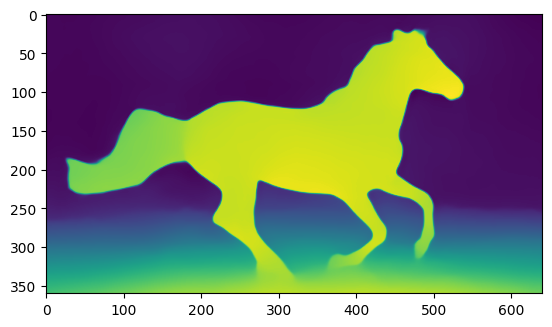

In [15]:
import matplotlib.pyplot as plt
plt.imshow((prediction.cpu()))

In [8]:
import cv2
import torch
import sys
sys.path.append('/nfs/home/wldn1677/lgd')
from Depth_Anything_V2.depth_anything_v2.dpt import DepthAnythingV2

DEVICE = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

model_configs = {
    'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
    'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
    'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]},
    'vitg': {'encoder': 'vitg', 'features': 384, 'out_channels': [1536, 1536, 1536, 1536]}
}

encoder = 'vits' # or 'vits', 'vitb', 'vitg'

model = DepthAnythingV2(**model_configs[encoder])
model.load_state_dict(torch.load(f'/nfs/home/wldn1677/lgd/Single-image-to-Right-image/ckpts/depth_anything_v2_{encoder}.pth', map_location='cpu'))
model = model.to(DEVICE).eval()

raw_img = cv2.imread('/nfs/home/wldn1677/lgd/Single-image-to-Right-image/images/horse.png')
depth = model.infer_image(raw_img) # HxW raw depth map in numpy

xFormers not available
xFormers not available
/nfs/home/wldn1677/lgd/Single-image-to-Right-image/ipykernel_568176/1399376722.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental featur

In [28]:
depth

array([[0.2249228 , 0.21038285, 0.21132325, ..., 0.14684762, 0.14894445,
        0.15549797],
       [0.21892248, 0.2157284 , 0.21117803, ..., 0.14705257, 0.1471155 ,
        0.1487332 ],
       [0.21226208, 0.2103908 , 0.2083147 , ..., 0.1444045 , 0.1453924 ,
        0.14604592],
       ...,
       [2.9057953 , 2.907635  , 2.9016426 , ..., 3.178411  , 3.179296  ,
        3.1912944 ],
       [2.9339118 , 2.933807  , 2.932593  , ..., 3.2158458 , 3.213064  ,
        3.194954  ],
       [2.9222934 , 2.936177  , 2.9630938 , ..., 3.2466211 , 3.225303  ,
        3.2532647 ]], dtype=float32)

In [1]:
from models import MonocularDepthModel
model = MonocularDepthModel()

xFormers not available
xFormers not available
INFO:dinov2:using MLP layer as FFN
/nfs/home/wldn1677/lgd/Single-image-to-Right-image/models.py:195: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this expe

In [2]:
import cv2
import torch
raw_img = cv2.imread('/nfs/home/wldn1677/lgd/Single-image-to-Right-image/images/horse.png')
depth = model.get_depth_map(raw_img)

INFO:root:Generating monocular depth image.


In [3]:
depth.shape

(360, 640)

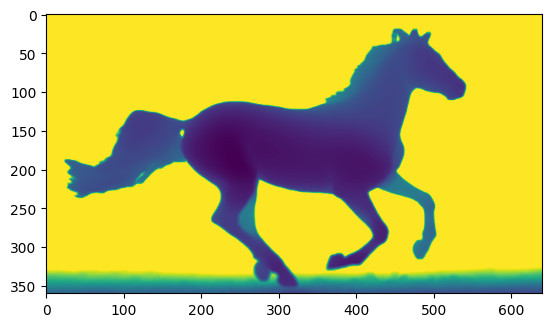

In [4]:
import matplotlib.pyplot as plt
plt.imshow((depth))